In [1]:
import numpy as np
import os
import cv2
from colorthief import ColorThief
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [4]:
# Set random seeds

np.random.seed(42)
tf.random.set_seed(42)





def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Preprocess color extraction
def preprocessing_data(data_dirs, image_size, batch_size):
    datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = []
    labels = []
    colors = []  # Store dominant colors

    for label, data_dir in enumerate(data_dirs):
        for file_name in os.listdir(data_dir):
            image_path = os.path.join(data_dir, file_name)
            eye_image = cv2.imread(image_path)
            eye_image = cv2.resize(eye_image, (image_size, image_size))

            # Extract dominant color using ColorThief

            color_thief = ColorThief(image_path)
            dominant_color = color_thief.get_color(quality=1)
            normalized_color = [float(c) / 255.0 for c in dominant_color]
            colors.append(normalized_color)


            eye_image = np.expand_dims(eye_image, axis=0)
            augmented_images = datagenerator.flow(eye_image, batch_size=batch_size)
            for batch in augmented_images:
                images.append(batch[0])
                labels.append(label)
                break

    return np.array(images), np.array(labels), np.array(colors)


In [5]:
BASE_DIR = "./Data/"
jaundiced_dir = os.path.join(BASE_DIR, "Jaundiced Eyes/")
normal_dir = os.path.join(BASE_DIR, "Normal Eyes/")

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(jaundiced_dir))} images of Jaundiced Eyes.")
print(f"There are {len(os.listdir(normal_dir))} images of Normal Eyes.")



There are 138 images of Jaundiced Eyes.
There are 248 images of Normal Eyes.


In [6]:
# setup

data_dirs = [jaundiced_dir, normal_dir]

image_size = 100
batch_size = 40


def preprocessing_data(data_dirs, image_size, batch_size):
    datagenerator = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = []
    labels = []
    colors = []  # Store dominant colors

    for label, data_dir in enumerate(data_dirs):
        for file_name in os.listdir(data_dir):
            image_path = os.path.join(data_dir, file_name)
            eye_image = cv2.imread(image_path)

            # Check if image is loaded correctly
            if eye_image is None:
                print(f"Error loading image: {image_path}. Skipping...")
                continue  # Skip to the next file

            eye_image = cv2.resize(eye_image, (image_size, image_size))

            # Extract dominant color using ColorThief

            color_thief = ColorThief(image_path)
            dominant_color = color_thief.get_color(quality=1)
            normalized_color = [float(c) / 255.0 for c in dominant_color]
            colors.append(normalized_color)


            eye_image = np.expand_dims(eye_image, axis=0)
            augmented_images = datagenerator.flow(eye_image, batch_size=batch_size)
            for batch in augmented_images:
                images.append(batch[0])
                labels.append(label)
                break

    return np.array(images), np.array(labels), np.array(colors)

from sklearn.model_selection import train_test_split

images, labels, colors = preprocessing_data(data_dirs, image_size, batch_size)
# Split data into training and testing sets
X_training, X_tests, y_training, y_tests, colors_training, colors_tests = train_test_split(
    images, labels, colors, test_size=0.2, random_state=50)

In [7]:
image_input = Input(shape=(image_size, image_size, 3), name='image_input')
color_input = Input(shape=(3,), name='color_input')



x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)



# Combine the CNN output with color data

combined_features = Concatenate()([x, color_input])

z = Dense(64, activation='relu')(combined_features)
z = Dropout(0.5)(z)
final_output = Dense(1, activation='sigmoid')(z)



model = Model(inputs=[image_input, color_input], outputs=final_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 32)   896         ['image_input[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 49, 49, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 47, 47, 64)   18496       ['max_pooling2d[0][0]']      

Epoch 1/100
8/8 [==============================] - 2s 196ms/step - loss: 0.6591 - accuracy: 0.6136 - val_loss: 0.7389 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 166ms/step - loss: 0.6531 - accuracy: 0.7273 - val_loss: 0.6496 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 170ms/step - loss: 0.5577 - accuracy: 0.7273 - val_loss: 0.4940 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 171ms/step - loss: 0.4577 - accuracy: 0.8084 - val_loss: 0.3586 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 165ms/step - loss: 0.4073 - accuracy: 0.8279 - val_loss: 0.4896 - val_accuracy: 0.7436 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 1s 169ms/step - loss: 0.3970 - accuracy: 0.8247 - val_loss: 0.5227 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 1s 174ms/step - loss: 0.3

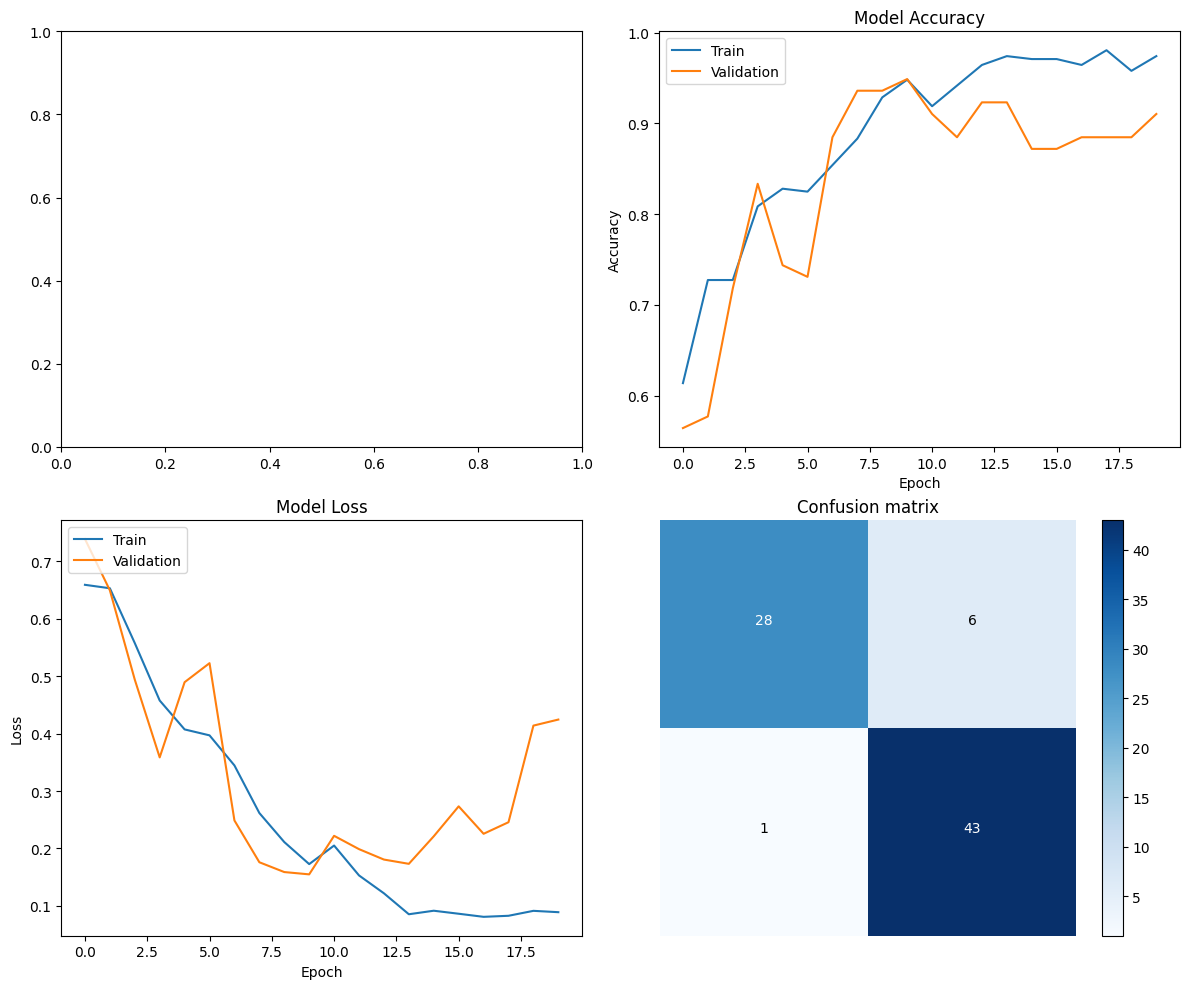

In [8]:
# Train

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history = model.fit([X_training, colors_training], y_training, epochs=100, batch_size=batch_size,
                    validation_data=([X_tests, colors_tests], y_tests), callbacks=[early_stopping, reduce_lr])

# Evaluate
y_pred_prob = model.predict([X_tests, colors_tests])
y_pred_classes = (y_pred_prob > 0.3).astype(int)
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
cm = confusion_matrix(y_tests, y_pred_classes)
plot_confusion_matrix(cm, classes=['No Jaundice', 'Jaundice'])

ax[0, 1].plot(history.history['accuracy'], label='Train')
ax[0, 1].plot(history.history['val_accuracy'], label='Validation')
ax[0, 1].set_title('Model Accuracy')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].legend(loc='upper left')


# Model loss
ax[1, 0].plot(history.history['loss'], label='Train')
ax[1, 0].plot(history.history['val_loss'], label='Validation')
ax[1, 0].set_title('Model Loss')
ax[1, 0].set_ylabel('Loss')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].legend(loc='upper left')
ax[1, 1].axis('off')

accuracy = accuracy_score(y_tests, y_pred_classes)
precision = precision_score(y_tests, y_pred_classes)
recall = recall_score(y_tests, y_pred_classes)
f1 = f1_score(y_tests, y_pred_classes)

print('Accuracy:', round(accuracy * 100, 2), '%')
print('Precision:', round(precision * 100, 2), '%')
print('Recall:', round(recall * 100, 2), '%')
print('F1 Score:', round(f1 * 100, 2), '%')

plt.tight_layout()
plt.show()

In [28]:
import ipywidgets as widgets


uploaded = widgets.FileUpload(accept="image/*", multiple=True)
display(uploaded)
out = widgets.Output()
display(out)


image_size = 100  

temp_dir = "temp_files"
os.makedirs(temp_dir, exist_ok=True) 


def process_uploaded_files(change):
    """Proses file yang diunggah ketika terjadi perubahan di widget."""
    with out:
        out.clear_output()

        for file_data in uploaded.value:
            file_name = file_data['name']
            file_content = file_data['content']
            
            print(f'User uploaded file "{file_name}" with length {len(file_content)} bytes')
            try:

                temp_file_path = os.path.join(temp_dir, file_name)
                with open(temp_file_path, "wb") as temp_file:
                    temp_file.write(file_content)

  
                file_bytes = np.frombuffer(file_content, np.uint8)
                img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (image_size, image_size))

  
                color_thief = ColorThief(temp_file_path) 
                dominant_color = color_thief.get_color(quality=1)
                normalized_color = [float(c) / 255.0 for c in dominant_color]

               
                img = np.expand_dims(img, axis=0) / 255.0

               
                prediction = model.predict([img, np.array([normalized_color])])

                if prediction[0][0] > 0.5:
                    print(f"The image {file_name} is classified as Normal Eye")
                else:
                    print(f"The image {file_name} is classified as Jaundiced Eye")

              
                try:
                   
                    img_display = (img[0] * 255).astype(np.uint8) 
                    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))  
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Error displaying image: {e}")

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

            finally:
              
                if os.path.exists(temp_file_path):
                    os.remove(temp_file_path)


uploaded.observe(process_uploaded_files, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [9]:
model.save("jaundice_detector.keras")